In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [15]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [19]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

/var/folders/cq/wsfxg3tj55lgrg2204r316fc0000gn/T/ipykernel_2407/3652908780.py:7: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [20]:
# View all of the classes that automap found

print(Base.classes.keys())

['station', 'measurement']


In [21]:
# Save references to each table

Measurement = Base.classes.measurement  
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [36]:
# Find the most recent date in the data set.

recent_date = session.query(func.max(Measurement.date)).scalar()

print(recent_date)

2017-08-23


<Figure size 1000x500 with 0 Axes>

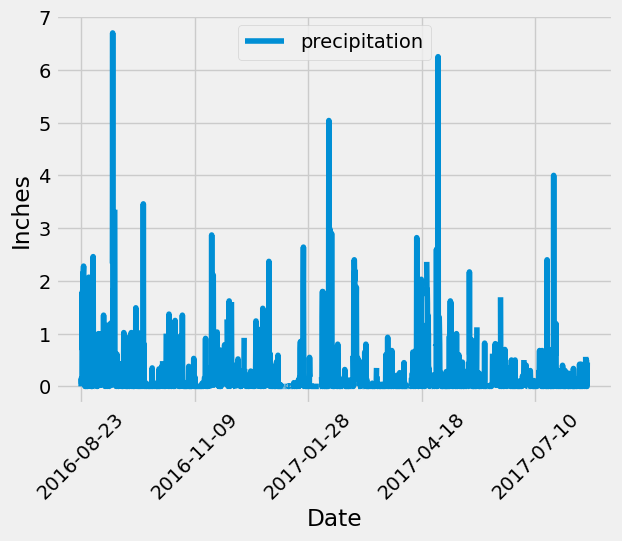

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

oneyr_ago = session.query(func.date(recent_date, "-1 year")).scalar()

# Perform a query to retrieve the data and precipitation scores

prcp_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= oneyr_ago)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(prcp_data, columns=["date", "prcp"])

# Sort the dataframe by date

df = df.sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10, 5))
df.plot(x="date", y="prcp", kind="line", legend=True, label="precipitation")

plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [43]:
# Use Pandas to calculate the summary statistics for the precipitation data

stats = df["prcp"].describe()
print(stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [44]:
# Design a query to calculate the total number of stations in the dataset

stations_count = session.query(Station).count()
print(stations_count)

9


In [49]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

for station, count in active_stations:
    print(f"{station}, {count}")

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = active_stations[0][0]

temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs), 
    func.avg(Measurement.tobs)  
).filter(Measurement.station == most_active_station).all()

print(temperature_stats)

[(54.0, 85.0, 71.66378066378067)]


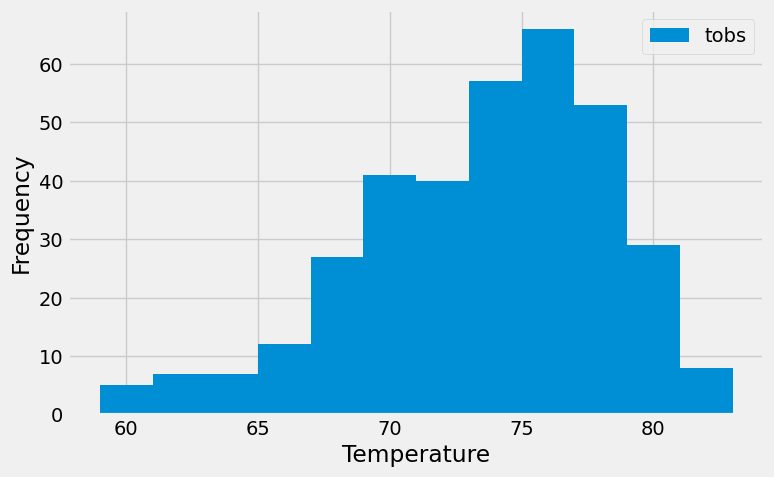

In [60]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_data = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station,
    Measurement.date >= oneyr_ago
).all()

temps = [temp[0] for temp in temperature_data]

plt.figure(figsize=(8, 5))
plt.hist(temps, bins=12, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Close Session

In [61]:
# Close Session
session.close()